In [1]:
import os

import tensorflow as tf
import numpy as np
import keras
import pandas as pd 
import imageio
import cv2
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2DTranspose, BatchNormalization, ReLU, Conv2D, UpSampling2D, MaxPool2D, Dropout
from keras import Input, Model

In [2]:
def preprocess_images_and_masks(folder_path, folder_path2):
  
    filenames = sorted(os.listdir(folder_path))
    filenames2 = sorted(os.listdir(folder_path2))

    images = [cv2.imread(os.path.join(folder_path, f)) for f in filenames]
    masks = [cv2.imread(os.path.join(folder_path2, f), cv2.IMREAD_GRAYSCALE) for f in filenames2]

    # Resize the images and masks to a desired size
    desired_size = (256, 256)
    images = [cv2.resize(image, desired_size) for image in images]
    masks = [cv2.resize(mask, desired_size, interpolation=cv2.INTER_NEAREST) for mask in masks]

    # Convert the images to RGB format (if they are not already)
    images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]

    # Normalize the pixel values of the images and masks
    images = [image / 255.0 for image in images]
    masks = [mask / 255.0 for mask in masks]

    # Convert the images and masks to numpy arrays
    images = np.array(images)
    masks = np.array(masks)

    return images, masks

In [3]:
images, masks = preprocess_images_and_masks('C:/Users/ambur/OneDrive/Desktop/FinalProject/I Unet/Unet_images/training_synapse', 
                            'C:/Users/ambur/OneDrive/Desktop/FinalProject/I Unet/Unet_images/labels')

In [4]:
# Check the dimensions of the images and masks arrays
if len(images) == 0 or len(masks) == 0:
    print("Error: Images or masks array is empty")
elif len(images) != len(masks):
    print("Error: Mismatch in number of images and masks")
else:
  # Shuffle the images and masks together
    combined = list(zip(images, masks))
    np.random.shuffle(combined)
    images, masks = zip(*combined)

    # Convert the images and masks to numpy arrays
    images = np.array(images)
    masks = np.array(masks)

    # Calculate the number of images in each split
    num_images = len(images)
    num_train = int(0.90 * num_images)
    num_val = int(0.075 * num_images)
    num_test = num_images - num_train - num_val

    # Split the images and masks into training, validation, and test sets
    train_images = images[:num_train]
    train_masks = masks[:num_train]
    val_images = images[num_train:num_train+num_val]
    val_masks = masks[num_train:num_train+num_val]
    test_images = images[num_train+num_val:]
    test_masks = masks[num_train+num_val:]


In [5]:
test_images.shape


(26, 256, 256, 3)

(256, 256, 3)


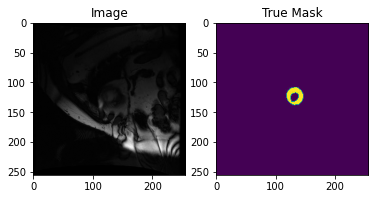

(256, 256, 3)


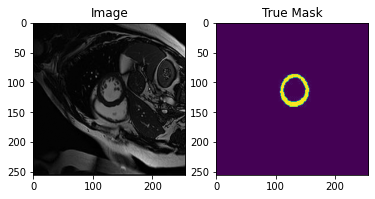

(256, 256, 3)


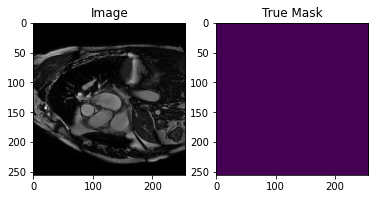

(256, 256, 3)


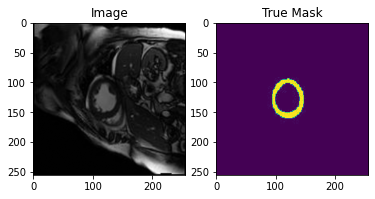

(256, 256, 3)


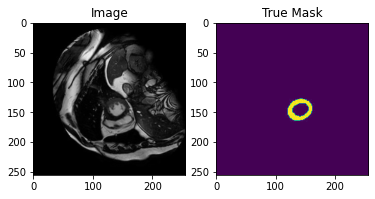

In [6]:
for i in range(5):
    image = images[i]
    print(image.shape)
    mask = masks[i]
    
    # Display the image and the true mask
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image)
    ax1.set_title("Image")
    ax2.imshow(mask)
    ax2.set_title("True Mask")

    plt.show()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 64)     256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 256, 256, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856 

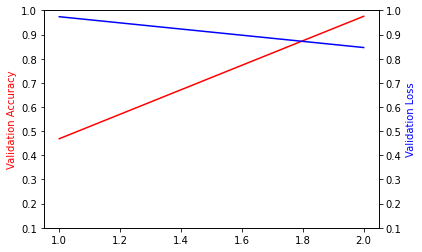

1/1 [==============================] - 1s 754ms/step


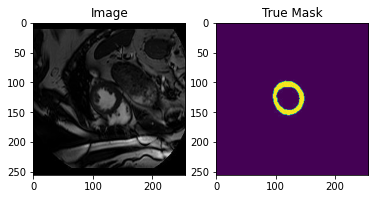

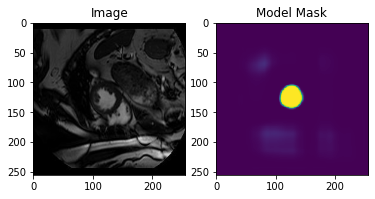

1/1 [==============================] - 4s 4s/step
Mean IoU on test set: 0.498
F1 score on test set: 0.232


In [7]:
def create_upsample_layer(filters, kernel_size, padding='same', kernel_initializer='he_normal'):
    """ This function creates a layer that upsamples an input tensor using a convolutional, batch
    normalization, and ReLU activation, followed by an upsampling operation. """
    def layer(x):
        x = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = UpSampling2D(size=(2, 2))(x)
        return x
    return layer

def create_downsample_layer(filters, kernel_size, padding='same', kernel_initializer='he_normal'):
    """ This function creates a layer that downsamples an input tensor using a convolutional, batch
    normalization, and ReLU activation, followed by a max pooling operation. """
    def layer(x):
        x = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = MaxPool2D(pool_size=(2, 2))(x)
        return x
    return layer

dropout_rate = 0.15

# Example usage
inputs = Input(shape=(256, 256, 3))

# Encoder part of the DeepUNet
x = create_downsample_layer(64, 3, padding='same', kernel_initializer='he_normal')(inputs)
x = create_downsample_layer(128, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_downsample_layer(256, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_downsample_layer(512, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_downsample_layer(1024, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_downsample_layer(2048, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)

# Decoder part of the DeepUNet
x = create_upsample_layer(1024, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(512, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(256, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(128, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(64, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(32, 3, padding='same', kernel_initializer='he_normal')(x)

outputs = Conv2D(1, 1, padding = 'same', activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()


# Define early stopping and reduce learning rate on plateau callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, 
                              verbose=1, mode='auto')

def dice_loss(y_true, y_pred):
    # Flatten the predictions and ground truth
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    
    # Compute the intersection and union
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)
    
    # Compute the Dice loss
    dice_loss = 1 - 2 * intersection / union
    
    return dice_loss

# Compile the model with the Dice loss
model.compile(loss=dice_loss, optimizer='adam', metrics=['accuracy'])

# Define the number of epochs and the batch size
num_epochs = 2
batch_size = 6

# Set seed
# tf.random.set_seed(42)
tf.random.set_seed(1)

# Train the UNet model on the training data
history = model.fit(#dataset,
                    train_images, 
                    train_masks,
                    batch_size=batch_size, epochs=num_epochs,
                    callbacks=[early_stop, reduce_lr],
                    validation_data=(val_images, val_masks))

# Epochs and corresponding val_loss and val_accuracy values
epochs_list = list(range(1, len(history.history['val_loss']) + 1))
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Plot the epoch vs val_loss
ax1 = plt.subplot(111)
ax1.plot(epochs_list, val_accuracy, 'r-')
ax1.set_ylabel('Validation Accuracy', color='r')

# Create a second y-axis for the val_accuracy
ax2 = ax1.twinx()
ax2.plot(epochs_list, val_loss, 'b-')
ax2.set_ylabel('Validation Loss', color='b')

# Set the same scaling on the y-axes
ax1.set_ylim([0.1, 1])
ax2.set_ylim([0.1, 1])

plt.show()


for i in range(1):
    # Select an image and its true mask
    image = test_images[i]
    mask = test_masks[i]

    # Make a prediction using the model
    prediction = model.predict(image[None, ...])[0]

    # Display the image and the true mask
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image)
    ax1.set_title("Image")
    ax2.imshow(mask)
    ax2.set_title("True Mask")

    # Display the image and the model's prediction
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image)
    ax1.set_title("Image")
    ax2.imshow(prediction)
    ax2.set_title("Model Mask")

    plt.show()

# Make predictions on the test images
predictions = model.predict(test_images)

# Compute the mean IoU metric on the test set
mean_iou = tf.keras.metrics.MeanIoU(num_classes=2)
mean_iou.update_state(test_masks, predictions)
print("Mean IoU on test set: {:.3f}".format(mean_iou.result()))

# Compute the precision and recall on the test set
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

precision.update_state(test_masks, predictions)
recall.update_state(test_masks, predictions)

# Compute the F1 score on the test set
f1_score = 2 * (precision.result() * recall.result()) / (precision.result() + recall.result())
print("F1 score on test set: {:.3f}".format(f1_score))

# Reset the metrics
mean_iou.reset_states()
precision.reset_states()
recall.reset_states()

In [2]:
mean_iou = 0.498
Mean_Dice = 2 * (mean_iou) / (1 + mean_iou)
print(Mean_Dice)


0.664886515353805
